In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd 
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sbn 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('./src/')
%aimport lib

In [2]:
class EFM_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['neratinib']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [2]
        self.batch_correct = [True]

class EFM_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]

class SKB_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['neratinib']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [0]
        self.batch_correct = [True]

class SKB_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]


In [3]:
## USE this to choose the experiment arguments - modify cell above to change

args = SKB_neratinib()

#args = SKB_trastuzumab()
#args = EFM_neratinib()
#args = EFM_trastuzumab()

In [4]:
data, clover_sel, mscarl_sel = lib.load_data(args)
data.head()


loading data...
# of datasets to load: 13


,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant
0,79_1000188375_skbr3_erk_akt__wt_untreated,0.240343,0.305148,0.359093,0.377887,0.430450,0.472083,0.470617,0.594090,0.594985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
1,3_1000012495_skbr3_erk_akt__wt_untreated,0.258892,0.323697,0.405762,0.422704,0.424451,0.429620,0.416867,0.365984,0.361178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
2,79_1000188229_skbr3_erk_akt__wt_untreated,0.360215,0.425021,0.478966,0.501633,0.601752,0.611347,0.571254,0.543516,0.737053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
3,1_1000003862_skbr3_erk_akt__wt_untreated,0.724460,0.693145,0.805601,0.818410,0.727231,0.674704,0.707653,0.679908,0.713188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
4,3_1000012346_skbr3_erk_akt__wt_untreated,0.526140,0.678670,0.609742,0.562597,0.607743,0.511163,0.552604,0.780575,0.673951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT


In [5]:
data, clover_sel, mscarl_sel = lib.filter_data(args, data, clover_sel, mscarl_sel)


filtering to drug and removing NAs...
drug id: neratinib
Data shape (untreated + drug): (23672, 398)
length of time series BEFORE removing time points with NA 150
length of time series AFTER removing time points with NA 135


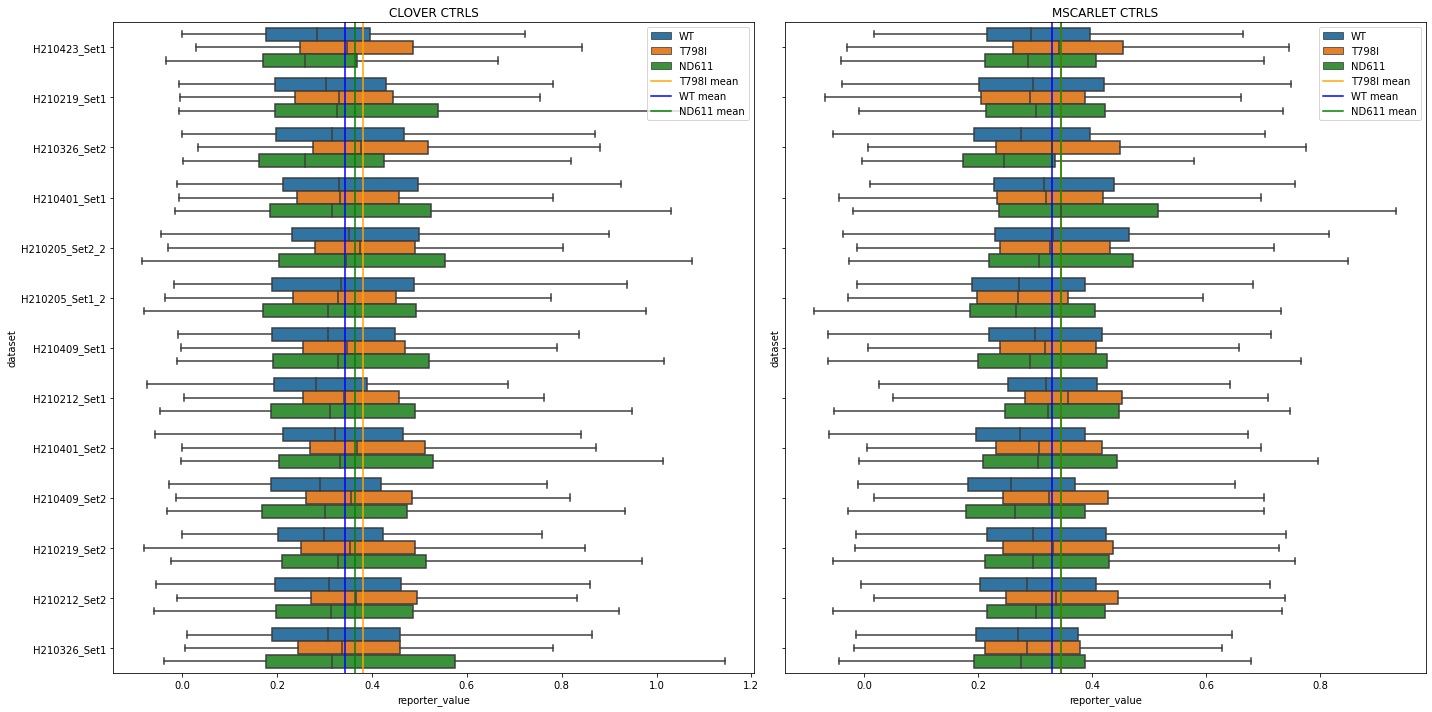

In [11]:
data_ctrls = lib.plot_reporter_batch_effects(data, args, clover_sel, mscarl_sel, save=None)

In [115]:
batch_lvls = ['NONE'] + sorted(list(data_ctrls.dataset.unique())) # have to include None as a level to enforce one-hot encoding for batches (otherwise the first batch will be used as level zero and not included)

# any reason to include treatment or cell_line ? 
#y, X = dmatrices('value ~ C(dataset, levels=batch_lvls)', data=data_ctrls, return_type='dataframe')
y, X = dmatrices('reporter_value ~ dataset', data=data_ctrls, return_type='dataframe')

In [116]:
# test for batch effect
# this is usually significant for many batches ... but note how small the effect sizes are.
mod = sm.GLS(y, X) 
fit = mod.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:         reporter_value   R-squared:                       0.005
Model:                            GLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     693.4
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:55:53   Log-Likelihood:             4.6621e+05
No. Observations:             1528200   AIC:                        -9.324e+05
Df Residuals:                 1528187   BIC:                        -9.322e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3278      0.001    613.006      0.000       0.327       0.329
dataset[T.H210205_Set2_2]     0.0450      0.001     65.402      0.000       0.044       0.046
dataset[T.H210212_Set1]       0.0267      0.001     36.669      0.000       0.025       0.028
dataset[T.H210212_Set2]       0.0296      0.001     38.073      0.000       0.028       0.031
dataset[T.H210219_Set1]       0.0070      0.001      9.915      0.000       0.006       0.008
dataset[T.H210219_Set2]       0.0190      0.001     26.748      0.000       0.018       0.020
dataset[T.H210326_Set1]       0.0013      0.001      1.552      0.121      -0.000       0.003
dataset[T.H210326_Set2]       0.0227      0.001     28.503      0.000       0.021       0.024
dataset[T.H210401_Set1]       0.0300      0.001     38.864      0.000       0.028       0.032
dataset[T.H210401_Set2]       0.0240      0.001     31.685      0.000       0.022       0.025
dataset[T.H210409_Set1]       0.0201      0.001     26.372      0.000       0.019       0.022
dataset[T.H210409_Set2]       0.0048      0.001      6.560      0.000       0.003       0.006
dataset[T.H210423_Set1]       0.0242      0.001     30.849      0.000       0.023       0.026
==============================================================================
Omnibus:                   237643.262   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           401838.704
Skew:                           1.037   Prob(JB):                         0.00
Kurtosis:                       4.418   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
batch_test1 = data[clover_sel.tolist() + ['dataset', 'mutant']][lambda x: x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]])].drop('mutant', axis=1).set_index('dataset').stack().reset_index().drop('level_1', axis=1).rename({0:'clover'}, axis=1).groupby('dataset').agg(['mean', 'std']).reset_index()
batch_test2 = data[mscarl_sel.tolist() + ['dataset', 'mutant']][lambda x: x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]])].drop('mutant', axis=1).set_index('dataset').stack().reset_index().drop('level_1', axis=1).rename({0:'mscarl'}, axis=1).groupby('dataset').agg(['mean', 'std']).reset_index()
batch_test = batch_test1.merge(batch_test2, on='dataset')
batch_test

/home/teddy/miniconda3/envs/lc_reporter/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


dataset    clover              mscarl          
                        mean       std      mean       std
0   H210205_Set1_2  0.349841  0.200829  0.291454  0.153340
1   H210205_Set2_2  0.357376  0.193757  0.332040  0.183592
2     H210212_Set1  0.317855  0.181812  0.298194  0.161503
3     H210212_Set2  0.354416  0.197911  0.303613  0.177791
4     H210219_Set1  0.342332  0.186898  0.309121  0.174952
5     H210219_Set2  0.347632  0.191228  0.315355  0.174212
6     H210326_Set1  0.350580  0.193525  0.289585  0.156058
7     H210326_Set2  0.355595  0.200407  0.319218  0.175430
8     H210401_Set1  0.362964  0.199966  0.324742  0.181368
9     H210401_Set2  0.374179  0.199648  0.320426  0.172658
10    H210409_Set1  0.354311  0.194145  0.312563  0.168251
11    H210409_Set2  0.340671  0.189675  0.305262  0.166190
12    H210423_Set1  0.342798  0.193784  0.326911  0.170790

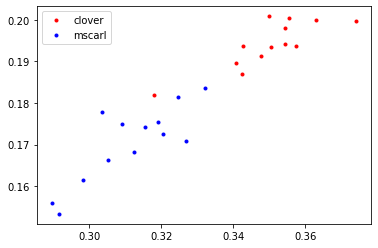

In [14]:
plt.figure()
plt.plot(batch_test[('clover','mean')], batch_test[('clover','std')], 'r.', label='clover')
plt.plot(batch_test[('mscarl','mean')], batch_test[('mscarl','std')], 'b.', label='mscarl')
plt.legend()
plt.show()

In [18]:
# eda 
data.dataset.unique()

array(['H210423_Set1', 'H210219_Set1', 'H210326_Set2', 'H210401_Set1',
       'H210205_Set2_2', 'H210205_Set1_2', 'H210409_Set1', 'H210212_Set1',
       'H210401_Set2', 'H210409_Set2', 'H210219_Set2', 'H210212_Set2',
       'H210326_Set1'], dtype=object)

In [19]:
data[lambda x: x.mutant.isin(['T798I', 'WT', 'ND611'])].groupby(['dataset', 'mutant']).count()[['track_index']]

track_index
dataset        mutant             
H210205_Set1_2 ND611           157
               T798I           152
               WT              260
H210205_Set2_2 ND611           158
               T798I           259
               WT              371
H210212_Set1   ND611           226
               T798I           253
               WT              231
H210212_Set2   ND611           176
               T798I           176
               WT              196
H210219_Set1   ND611           381
               T798I           285
               WT              274
H210219_Set2   ND611           193
               T798I           185
               WT              355
H210326_Set1   ND611            70
               T798I           131
               WT              192
H210326_Set2   ND611            43
               T798I           124
               WT              212
H210401_Set1   ND611           132
               T798I           196
               WT              184
H210401_Set2   ND611           104
               T798I           177
               WT              235
H210409_Set1   ND611           121
               T798I           177
               WT              221
H210409_Set2   ND611           119
               T798I           177
               WT              280
H210423_Set1   ND611            89
               T798I           199
               WT              158

In [20]:
data.mutant.unique()

array(['WT', 'T798I', 'ND611', 'P579L', 'R288Q', 'A37T', 'D933Y', 'E405D',
       'F976L', 'L755S', 'S609C', 'T479M', 'W906C', 'Y64F', 'D277H',
       'D638H', 'M889I', 'N488S', 'Q1206K', 'W825', 'A1039T', 'E975Q',
       'S310F', 'R34W', 'R929WL', 'S963', 'V797A', 'Y722V773INSRDGE',
       'L1197F', 'ND648', 'A355QFS76', 'D639E', 'Y835F', 'V842I', 'R678Q',
       'V424I', 'S310Y', 'T306M', 'L313V', 'T733I', 'L755T759DEL',
       'I767M', 'N427K', 'P232S', 'R190Q', 'A1160V', 'T297I', 'T862S',
       'V697L', 'D769Y', 'E717K', 'E744D', 'G621AFS31', 'I435L', 'I886M',
       'R1153L', 'Y1127A1129DEL', 'R897G', 'P523S', 'D769N',
       'E770A771INSGIRD', 'D873G', 'G1055C', 'G778S779INSLPS', 'H470Q',
       'H878Y', 'L662V', 'M833I', 'L43V', 'P416T', 'P702L', 'R203P',
       'R340G', 'R456C', 'R47C', 'L785F', 'L869R', 'P122L', 'S305C',
       'W482GFS74', 'E939G', 'G727A'], dtype=object)

# BURN IN

In [22]:
# add burnin 
clover_sel = clover_sel[args.burnin[0]:]
mscarl_sel = mscarl_sel[args.burnin[0]:]

In [23]:
X_train = lib.resample(args, data, clover_sel, mscarl_sel)



resampling time series...
Training data shape BEFORE resampling: (23672, 135, 2)
Training data shape AFTER resampling: (23672, 100, 2)



performing time-series kmeans clustering...

4.000 --> 3.315 --> 3.208 --> 3.150 --> 3.115 --> 3.093 --> 3.081 --> 3.073 --> 3.069 --> 3.067 --> 3.065 --> 3.064 --> 3.063 --> 3.062 --> 3.062 --> 3.061 --> 3.060 --> 3.060 --> 3.059 --> 3.059 --> 3.059 --> 3.059 --> 3.059 --> 3.058 --> 3.058 --> 3.058 --> 3.058 --> 3.058 --> 3.058 --> 3.058 --> 3.057 --> 3.057 --> 3.057 --> 3.057 --> 3.057 --> 3.057 --> 3.057 --> 3.056 --> 3.056 --> 3.056 --> 3.056 --> 3.055 --> 3.055 --> 3.055 --> 3.054 --> 3.054 --> 3.054 --> 3.054 --> 3.053 --> 3.053 --> 
plotting...


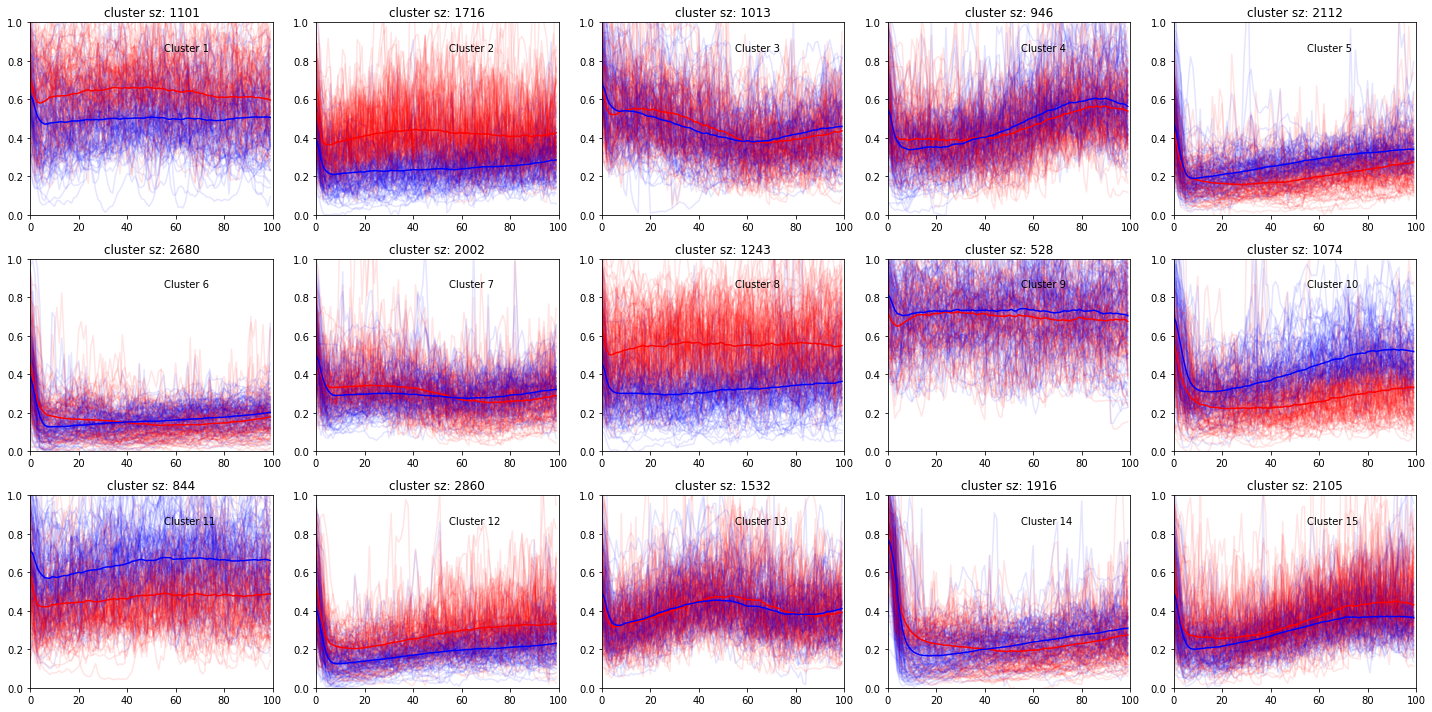

In [24]:
y_pred, km = lib.fit_kmeans(args, X_train, save=None)

In [25]:
cm, lb = lib.calc_cluster_proportions(args, y_pred, data)


quantifying experiment by cluster proportions...


<Figure size 504x504 with 0 Axes>

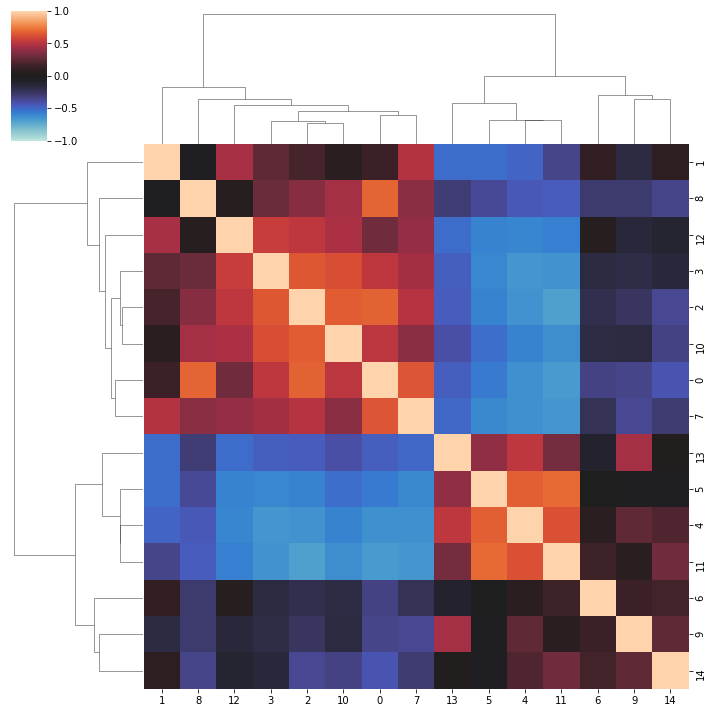

In [26]:
lib.plot_cluster_corr(cm, save=None)


performing dim. reduction (pca)...
PCA explained variance ratio: [0.5255183  0.12048225]
PC shape: (252, 2)


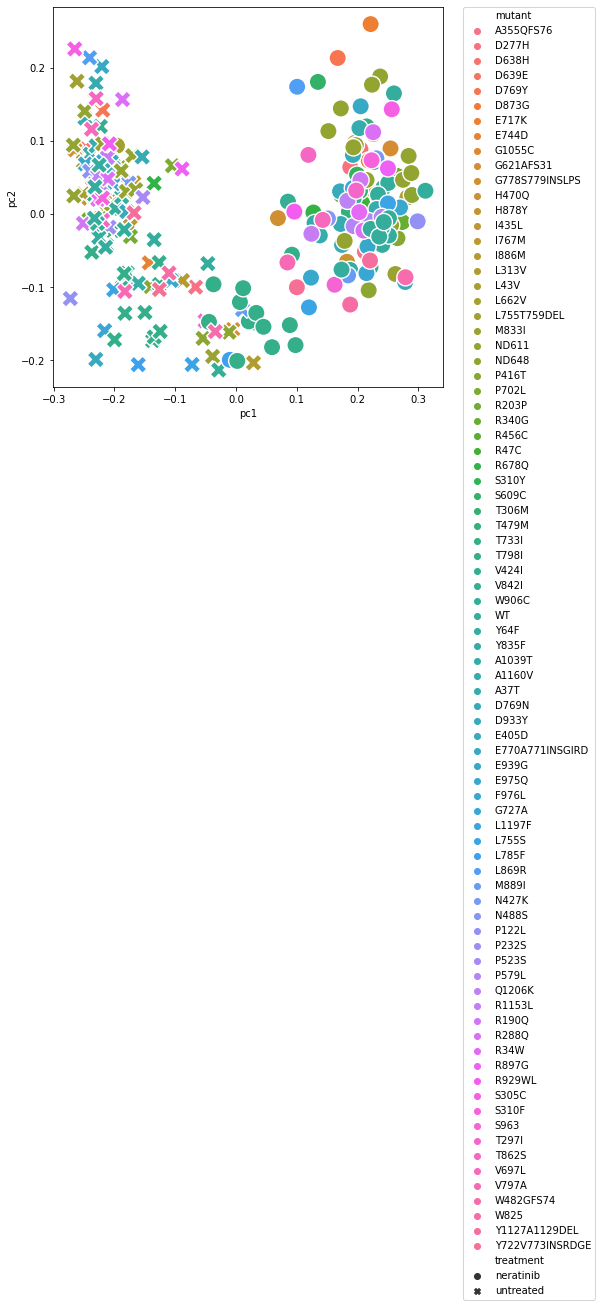

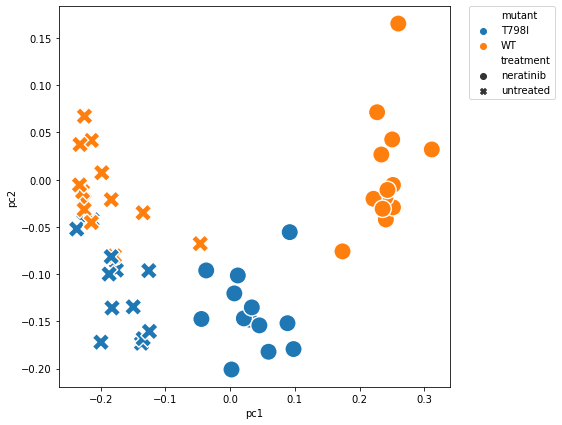

In [86]:
pca, res, _sens, _res, _drug = lib.dimensionality_reduction(args, cm, lb, save=None)

# Add the `cell counts`

In [87]:
cell_cnts = data.groupby(['mutant', 'drug', 'dataset'])['track_index'].count().reset_index().rename({'track_index':'cell_count'}, axis=1).assign(dataset=lambda x: x.dataset.str.upper())
res = res.merge(cell_cnts, left_on=['mutant', 'treatment', 'batch'], right_on=['mutant', 'drug', 'dataset'], how='left', validate='1:1').drop(['drug', 'dataset'], axis=1)

# Visualize batch effects 

(then we'll check and correct)

In [88]:
plt.figure(figsize=(5, 10)) 
sbn.boxplot(y='batch', x='pc1_uncor', data=res[lambda x: (x.mutant.isin([args.resistant_line[0], args.sensitive_line[0]]))])
plt.show()

ValueError: Could not interpret input 'pc1_uncor'

<Figure size 360x720 with 0 Axes>

# Test for batch effects 

We do this by running a regression based on batch (filtered to controls). 

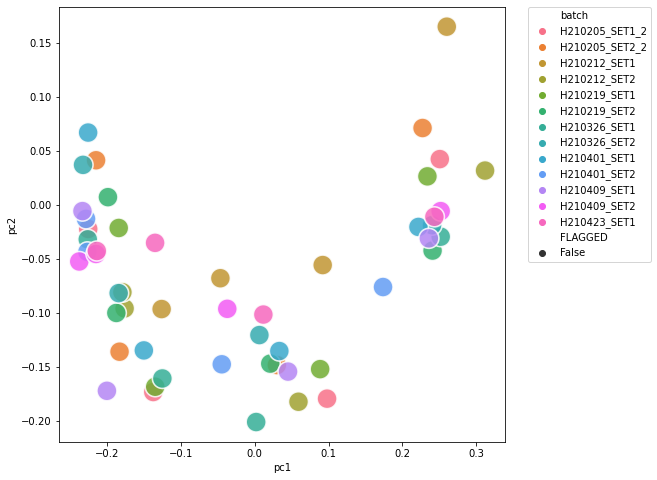

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210205_SET1_2,0.019259,0.847684,-0.023356,0.577394,dummy_id
1,H210205_SET2_2,-0.012299,0.902361,0.016882,0.686850,dummy_id
2,H210212_SET1,0.067669,0.500909,0.046071,0.274473,dummy_id
3,H210212_SET2,0.026758,0.789621,-0.022008,0.599463,dummy_id
4,H210219_SET1,0.023713,0.813072,-0.019061,0.649073,dummy_id


In [ ]:
batch_res = lib.get_batch_effects(args, res, 'dummy_id', save=None)
batch_res.head()

# Batch Correction 

Subtract the regression coeficient for each batch (e.g., PCx controls mean by batch) from mutant PCx values. 

In [89]:
if args.batch_correct[0]: 
    res = lib.batch_correction(res, batch_res)
    res2 = res.assign(pc1_uncor=None, pc2_uncor=None)
else: 
    res = res.assign(pc1_uncor=None, pc2_uncor=None)
    res2 = res

In [90]:
res

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.212132,-0.051413
1,-0.054148,-0.116865,untreated,A355QFS76,H210205_SET2_2,87,-0.012299,0.902361,0.016882,0.686850,dummy_id,-0.066447,-0.099984
2,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.218522,0.036594
3,-0.203065,0.003779,untreated,D639E,H210205_SET2_2,104,-0.012299,0.902361,0.016882,0.686850,dummy_id,-0.215364,0.020660
4,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.213242,0.039383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,-0.175527,-0.109787,untreated,V797A,H210401_SET1,94,-0.007318,0.941809,0.003926,0.925222,dummy_id,-0.182844,-0.105860
248,0.228961,-0.024197,neratinib,WT,H210401_SET1,104,-0.007318,0.941809,0.003926,0.925222,dummy_id,0.221644,-0.020271
249,-0.217881,0.063241,untreated,WT,H210401_SET1,80,-0.007318,0.941809,0.003926,0.925222,dummy_id,-0.225199,0.067168
250,0.107548,-0.104113,neratinib,Y722V773INSRDGE,H210401_SET1,58,-0.007318,0.941809,0.003926,0.925222,dummy_id,0.100231,-0.100186


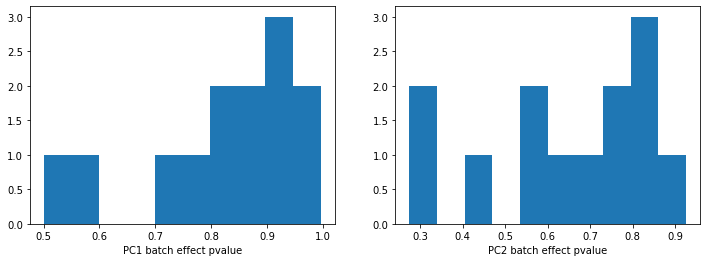

In [91]:
f,axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(batch_res.pc1_pval, bins=10)
axes[0].set_xlabel('PC1 batch effect pvalue')
axes[1].hist(batch_res.pc2_pval, bins=10)
axes[1].set_xlabel('PC2 batch effect pvalue')
plt.show()

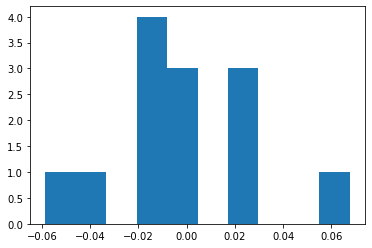

In [92]:
# batch effect sizes 
plt.figure() 
plt.hist(batch_res.pc1_coef)
plt.show()

# Finally, train classifier - predict mutant resistance/sensitivity


training classifier...
sensitive line: WT
resistant line: T798I
drug: neratinib
drug + WT df size:  (26, 13)
X train shape: (26, 2)
# neg class (resistant): 13
# pos class (sensitive): 13


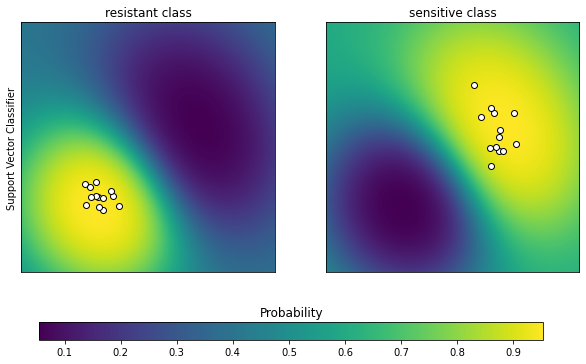

In [93]:
model, accuracy = lib.train_classifier(res, _sens, _res, _drug, save=None)

In [94]:
prob_res = lib.predict_new(args, res, model)
prob_res.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.212132,-0.051413,0.127947,0.872053,sens
1,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.218522,0.036594,0.053830,0.946170,sens
2,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.213242,0.039383,0.055517,0.944483,sens
3,0.230680,-0.121174,neratinib,ND648,H210205_SET2_2,66,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.218381,-0.104292,0.222904,0.777096,sens
4,0.139730,-0.014698,neratinib,R678Q,H210205_SET2_2,274,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.127431,0.002184,0.285403,0.714597,sens


In [95]:
prob_res.sort_values('prob_res', ascending=False).head()

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
56,0.032593,-0.160216,neratinib,T798I,H210212_SET2,76,0.026758,0.789621,-0.022008,0.599463,dummy_id,0.059351,-0.182224,0.945207,0.054793,res
5,0.042435,-0.165109,neratinib,T798I,H210205_SET2_2,141,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.030136,-0.148228,0.943878,0.056122,res
114,0.003608,-0.155029,neratinib,T798I,H210326_SET1,84,-0.001484,0.988193,-0.045999,0.275211,dummy_id,0.002125,-0.201028,0.942217,0.057783,res
104,0.014154,-0.137305,neratinib,T798I,H210401_SET2,94,-0.058560,0.559966,-0.010227,0.806942,dummy_id,-0.044406,-0.147531,0.941767,0.058233,res
36,0.029397,-0.136171,neratinib,T798I,H210219_SET2,86,-0.008222,0.934633,-0.010751,0.797266,dummy_id,0.021175,-0.146922,0.941356,0.058644,res


# How does batch effect correction change our results? 


In [102]:
prob_res_uncor = lib.predict_new(args, res2, model)
prob_res_uncor.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.127947,0.872053,sens
1,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.053830,0.946170,sens
2,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.055517,0.944483,sens
3,0.230680,-0.121174,neratinib,ND648,H210205_SET2_2,66,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.222904,0.777096,sens
4,0.139730,-0.014698,neratinib,R678Q,H210205_SET2_2,274,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.285403,0.714597,sens


In [97]:
comp = prob_res[['mutant', 'prob_res']].merge(prob_res_uncor[['mutant', 'prob_res']], on='mutant').assign(delta=lambda x: x.prob_res_x - x.prob_res_y)
comp.head()

,mutant,prob_res_x,prob_res_y,delta
0,A355QFS76,0.127947,0.127947,0.000000
1,D639E,0.053830,0.053830,0.000000
2,ND611,0.055517,0.055517,0.000000
3,ND611,0.055517,0.128812,-0.073295
4,ND611,0.055517,0.094487,-0.038970


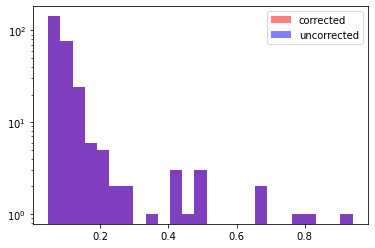

In [105]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_x, color='r', alpha=0.5, bins=25, label='corrected')
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_y, color='b', alpha=0.5, bins=25, label='uncorrected')
plt.yscale('log')
plt.legend()
plt.show()

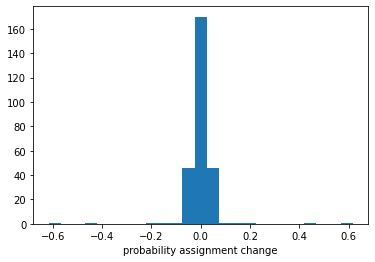

In [107]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].delta, bins=25)
plt.xlabel('probability assignment change')
plt.show()

In [108]:
# mutants with the most change
comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].sort_values('delta', ascending=False)

,mutant,prob_res_x,prob_res_y,delta
580,L755S,0.668342,0.051117,0.617225
576,F976L,0.505646,0.049156,0.456490
172,ND648,0.222904,0.047559,0.175345
564,A37T,0.208349,0.065252,0.143097
23,ND611,0.128812,0.054061,0.074750
...,...,...,...,...
107,ND611,0.054061,0.128812,-0.074750
565,A37T,0.065252,0.208349,-0.143097
173,ND648,0.047559,0.222904,-0.175345
577,F976L,0.049156,0.505646,-0.456490


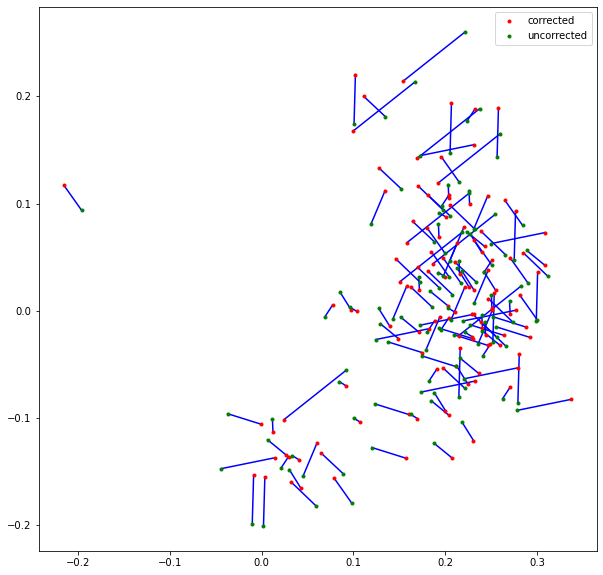

In [109]:
# how does batch effect correction change our results?

plt.figure(figsize=(10,10))
for i,row in prob_res.iterrows(): 
    plt.plot(row[['pc1_uncor', 'pc1']].values, row[['pc2_uncor', 'pc2']].values, 'b-')

plt.plot(prob_res['pc1'].values,prob_res['pc2'].values, 'r.', label='corrected')
plt.plot(prob_res['pc1_uncor'].values,prob_res['pc2_uncor'].values, 'g.', label='uncorrected')
plt.legend()
plt.show()